C:\Users\sungm\AppData\Local\Temp\ipykernel_4084\154729935.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  g = np.double(imageio.imread("DICImage.tif"))


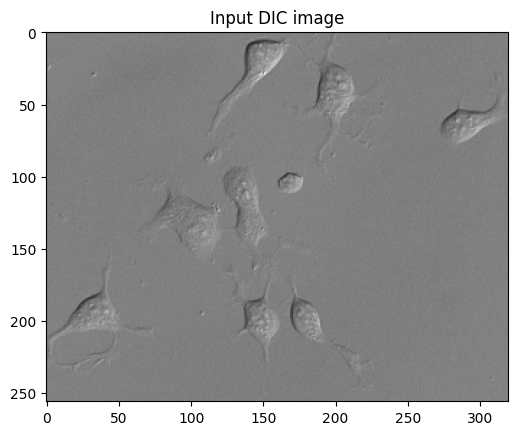

In [134]:
import numpy as np, scipy, skimage, time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy import ndimage
import imageio
import matplotlib.pyplot as plt


#read image
g = np.double(imageio.imread("DICImage.tif"))
nrows, ncols = g.shape
N = nrows*ncols

xx, yy = np.meshgrid(np.arange(1, ncols+1), np.arange(1, nrows+1))
xx = xx.flatten(); yy = yy.flatten()
X = np.column_stack((np.ones(N), xx, yy, xx**2, xx*yy, yy**2))
p = np.linalg.lstsq(X, g.flatten(), rcond=None)[0]
g = np.reshape(g.flatten()-np.dot(X, p), (nrows,ncols))
g = g/np.max(np.abs(g)) #image value in [-1,1]
plt.imshow(g,cmap='gray', vmin=-1, vmax=1); plt.title('Input DIC image'); plt.show()


In [135]:
#compute the H (imaging model), L (smooth) matrices
tt = time.process_time() #use time instead of cputime
#get the differential kernel for H
sigma = 1 #sigma in the first-derivative-of-Gaussian kernel
theta = 225*np.pi/180+np.pi #this parameter is related to this given image's microscope parameter
radius = max(2*np.ceil(sigma),1).astype(int)
diameter = 2*radius + 1
xx,yy = np.meshgrid(np.arange(-radius,radius+1),np.arange(-radius,radius+1))
tmp = np.exp(-0.5*(xx**2 + yy**2)/sigma**2)
h_kernel = -(np.cos(theta)*xx+np.sin(theta)*yy)*tmp
h_kernel = h_kernel/np.sum(np.abs(h_kernel))

#build the sparse H matrix
nzidx = np.abs(h_kernel.flatten()) > 0.001 #save memory and speed up by ignoring small elements
inds = np.arange(1, N+1).reshape(nrows, ncols)
inds_pad = np.pad(inds, ((radius, radius), (radius, radius)), mode='symmetric') #deal with the boundary
row_inds = np.repeat(np.arange(1, N+1), np.sum(nzidx))
col_inds = np.ravel(np.array([inds_pad[i:i+diameter, j:j+diameter] for i in range(nrows) for j in range(ncols)])) #slide col and then row
col_inds = col_inds[np.tile(nzidx, N)]
vals = np.tile(h_kernel.flatten()[nzidx], N)
H = sp.csr_matrix((vals, (row_inds-1, col_inds-1)), shape=(N, N))


#get the smooth kernel for L
hwid = 1; wid = 2*hwid + 1; nsz = wid**2
D = -np.ones((wid,wid))/(nsz-1)
D[hwid,hwid] = 1


# build the sparse L matrix
inds = np.reshape(np.arange(1, N + 1), (nrows, ncols))
inds_pad = np.pad(inds, ((hwid, hwid), (hwid, hwid)), mode='symmetric')
row_inds = np.tile(np.arange(1, N + 1), (nsz, 1))
col_inds = skimage.util.view_as_windows(inds_pad, (wid, wid), step=1).reshape(-1, wid**2).T
vals = np.tile(D.ravel(), (N, 1)).T
L = scipy.sparse.coo_matrix((vals.ravel(), (row_inds.ravel() - 1, col_inds.ravel() - 1)), shape=(N, N)).tocsr()
print(f'get H and L: {time.process_time() - tt:.3f} seconds')




get H and L: 0.125 seconds


In [136]:
gamma = 10
tol = 0.02
maxiter = 10000
w_sparsity = 0.0001
w_smooth = 0.1

# Your implementation below:

In [137]:
# combine g into a vector
g = g.flatten()

# init A, a vector that is the diagonal of a sparse matrix of ones of shape (N, N)
A = np.ones(N)

# initialize f, a vector of the same length as g, with all values of 1
f = np.ones(g.shape)
oldF = f

Q = H.transpose() * H + w_smooth * L
QPositive = Q.multiply(Q > 0)
QNegative = Q.multiply(Q < 0)
QNegative = np.abs(QNegative)

for iter in range(maxiter):

    b = -1 * H.transpose() * g + w_sparsity * A / 2

    numerator = -1*b + np.sqrt(b**2 + 4 * (QPositive * f) *(QNegative * f))
    denominator = 2 * QPositive * f
    f = f * numerator / denominator

    print(iter, np.linalg.norm(f - oldF))

    if np.linalg.norm(f - oldF) < tol and iter > 0:
        print("hit tolerance")
        break

    A = A / (f + gamma)
    oldF = f

0 7.425212166678449
1 4.3647249680257145
2 3.187884824798879
3 2.5802201870755264
4 2.2036182984407864
5 1.9429830351831519
6 1.7488009936397995
7 1.596397946812173
8 1.47219300092511
9 1.3681160937264294
10 1.2790606116842709
11 1.2016206941545535
12 1.1334222457463217
13 1.0727477512269759
14 1.0183151599075326
15 0.9691417759836173
16 0.9244572081239916
17 0.8836457855869125
18 0.8462073119746212
19 0.8117295974024344
20 0.77986877307369
21 0.7503348803765102
22 0.7228811178323628
23 0.6972956781524825
24 0.6733954544716728
25 0.6510211190807385
26 0.630033226083887
27 0.6103090891423617
28 0.5917402538425697
29 0.5742304318901157
30 0.557693798071914
31 0.5420535751596722
32 0.5272408495653332
33 0.5131935735595072
34 0.4998557195604863
35 0.4871765593143894
36 0.47511004636006937
37 0.46361428446135183
38 0.45265106802035937
39 0.44218548309540456
40 0.4321855597081258
41 0.4226219677649089
42 0.4134677502324433
43 0.40469808826824627
44 0.3962900938685094
45 0.38822262629934984
4

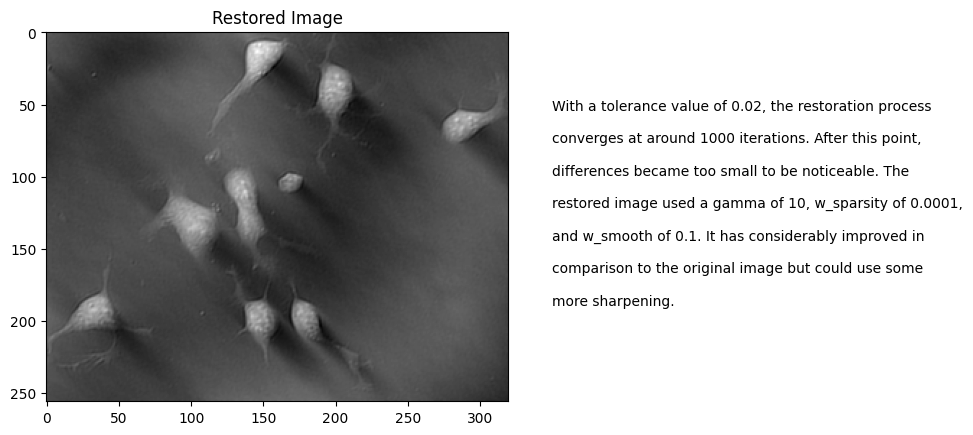

In [140]:
#print f
f = np.reshape(f, (nrows, ncols))
# f between 0 and 255
f = (f - np.min(f)) / (np.max(f) - np.min(f)) * 255

report = """
With a tolerance value of 0.02, the restoration process\n
converges at around 1000 iterations. After this point,\n
differences became too small to be noticeable. The\n
restored image used a gamma of 10, w_sparsity of 0.0001,\n
and w_smooth of 0.1. It has considerably improved in\n
comparison to the original image but could use some\n
more sharpening.
"""


plt.imshow(f, cmap='gray')
plt.title('Restored Image')
plt.text(350, 200, report, rotation=0)
plt.show()
